# Credit card customer segmentation
Problem statement: Given a dataset of a credit card company's clients, segregate the clients into different groups in order to apply different business strategies for each type of customer.
- Application of a K-means algorithm to segment the data.
The data is downloaded from [this Kaggle problem](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data) (accessed 16 Jan 2025).

Following is the Data Dictionary for Credit Card dataset :

- CUST_ID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases
- BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFF_PURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES : Amount of purchase done in installment
- CASH_ADVANCE : Cash in advance given by the user
- PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASES_TRX : Numbe of purchase transactions made
- CREDIT_LIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')

## Data Exploration

In [134]:
# Load the data
df = pd.read_csv('data/CC_GENERAL.csv')
print (df.shape)
print (df.info())
df.head()

(8950, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


There are 8950 rows with 18 columns including a unique identifier for each client. All columns contain numerical values with int and float types. 

The minimum payments column contain some missing values.
There seems to be one missing value in credit_limit column.

Let's replace the NaN in minimum payments by zero. The single row with missing value in credit_limit column is removed.

It would be quite interesting to see a correlation between the various variables. as a heat map.

In [135]:
# First remove the row with missing credit limit.
df = df.dropna(subset=['CREDIT_LIMIT'])

# Replace missing minimum payments by zeros.
df.loc[:, 'MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(0)

In [136]:
# Check if any NaN values exist
has_nan = df.isnull().values.any()
print("Contains NaN:", has_nan)

df = df.drop('CUST_ID', axis = 1)

Contains NaN: False


<Axes: >

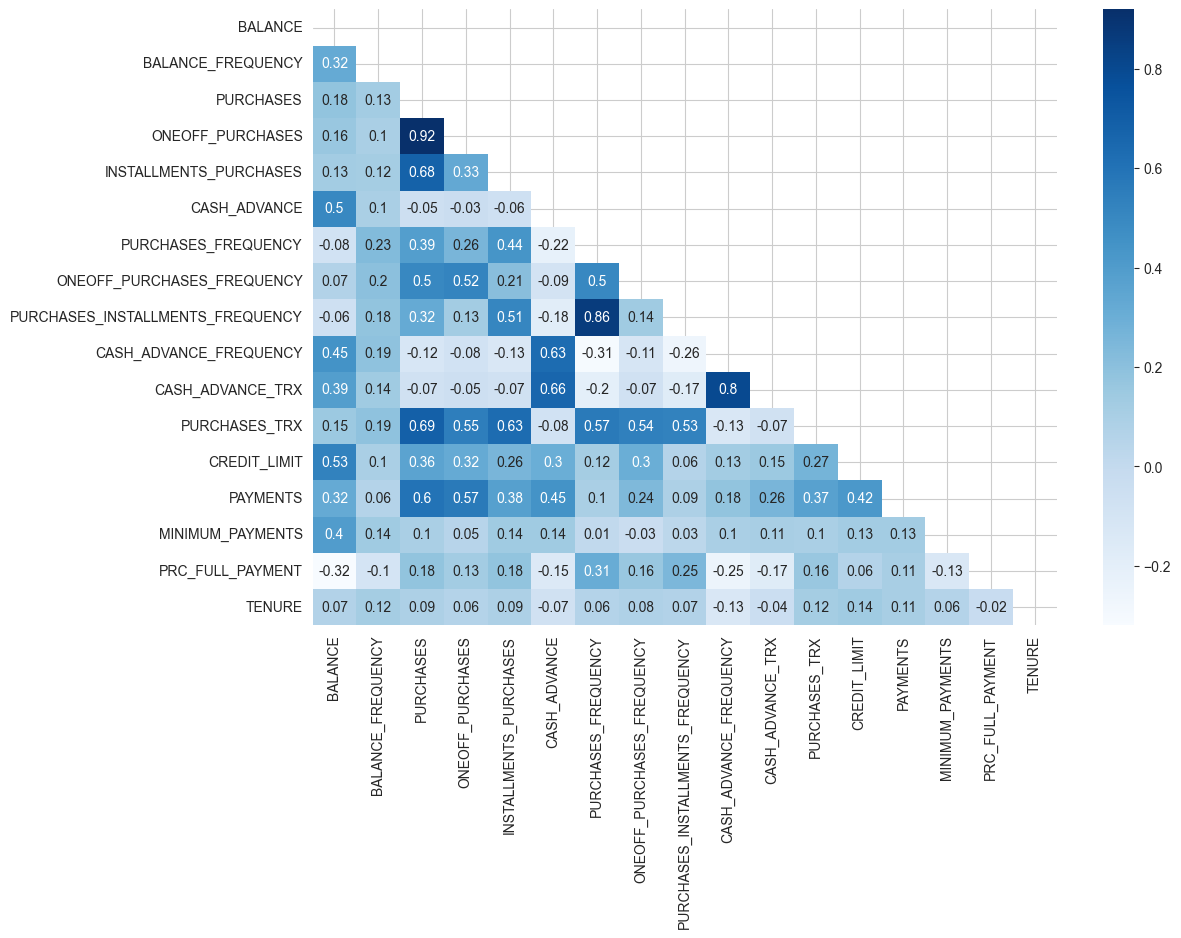

In [142]:

plt.figure(figsize= [12,8])
sns.heatmap( round (df.corr() , 2), cmap= 'Blues', annot=True, mask = np.triu(df.corr()) )
# plt.tight_layout()

There are several weak correlations, but we can highlight some strong ones:
- Purchases and one-off purchases.
- purchase frequency and purchase installments frequency.
- Cash advance frequency and cash advance transactions.

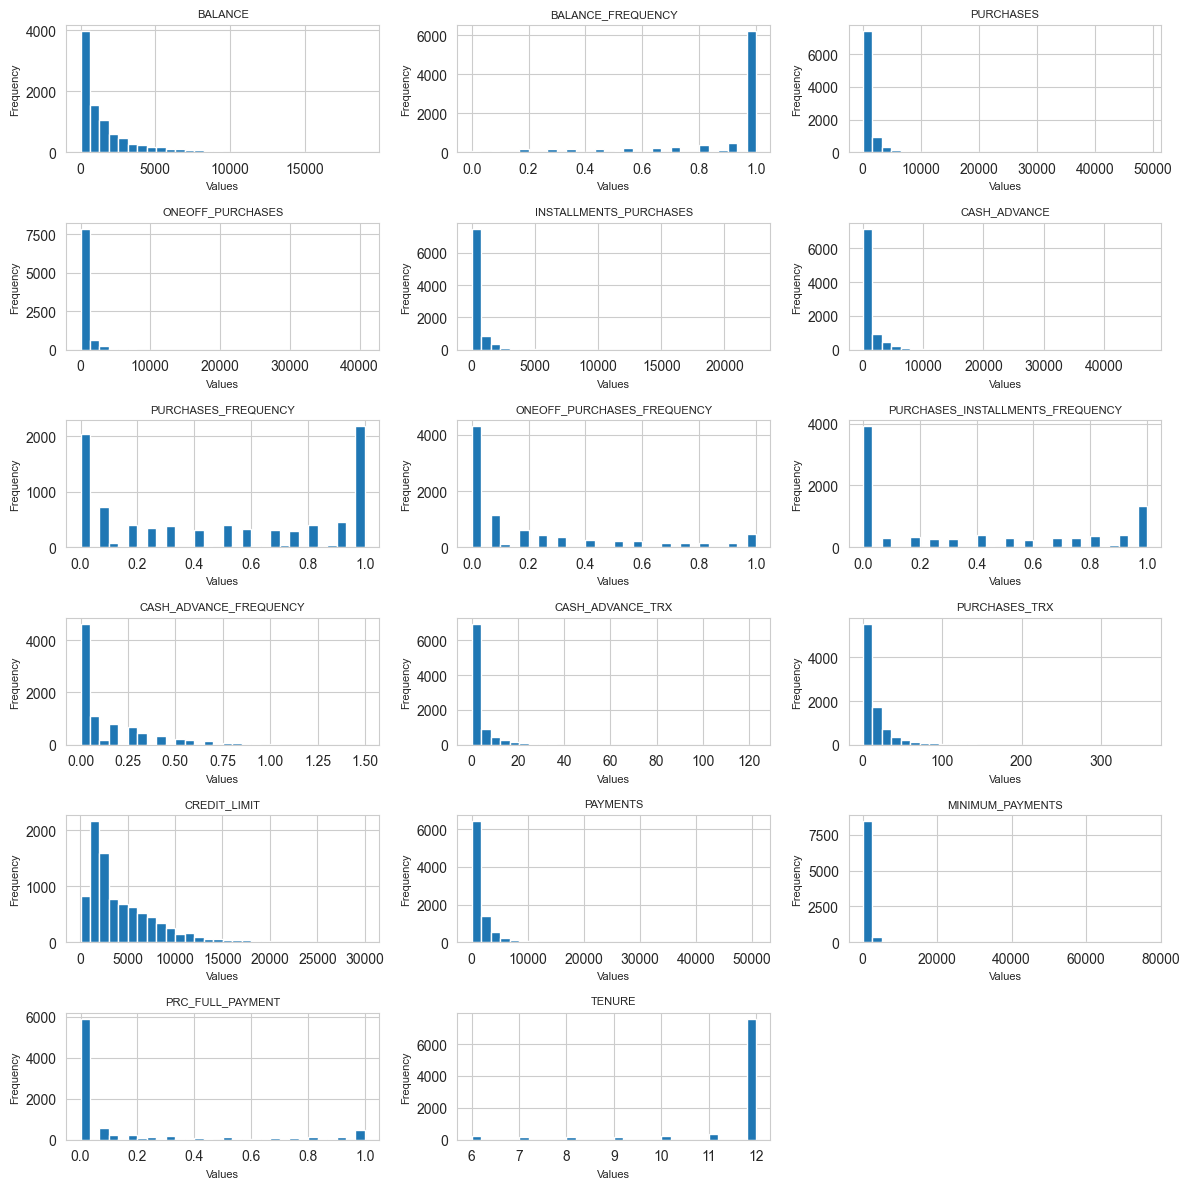

In [144]:
# Plot the histograms of all columns.
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,12))  # Adjust grid based on number of columns
axes = axes.flatten()  # Flatten for easier iteration

# Automatic font size adjustment
num_cols = len(df.columns)
fontsize = max(8, 15 - num_cols)  # Reduce font size dynamically

# Plot each column
for i, col in enumerate(df.columns):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col, fontsize=fontsize)
    axes[i].set_xlabel("Values", fontsize=fontsize)
    axes[i].set_ylabel("Frequency", fontsize=fontsize)

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

Interestingly nothing is normally distributed. Almost all distributions are skewed and multimodal.
We check a normalization technique to normalise the data. Since our data contains many zeros, it maybe useful to use Yeo-Johnson transformation (it is an extension of the more popular Box-Cox and log transformations for data with zeros or negative values.)
The Yeo-Johnson transformation is defined as:

$$
x' = \begin{cases}
    \dfrac{ [x+1]^\lambda -1 }{\lambda} , \quad & \text{if} \, x \ge 0, \lambda \ne 0 \\
    \text{ln} \left( x + 1 \right) , \quad & \text{if} \, x \ge 0, \lambda = 0 \\
    - \dfrac{[ |x| + 1 ]^{2-\lambda} - 1  }{2 - \lambda}, \quad & \text{if} \, x < 0, \lambda \ne 2 \\
    - \text{ln} \left( -x + 1 \right), \quad & \text{if} \, x< 0, \lambda = 2
\end{cases}
$$

We use it's implementation from SciPy's power_transform() function.


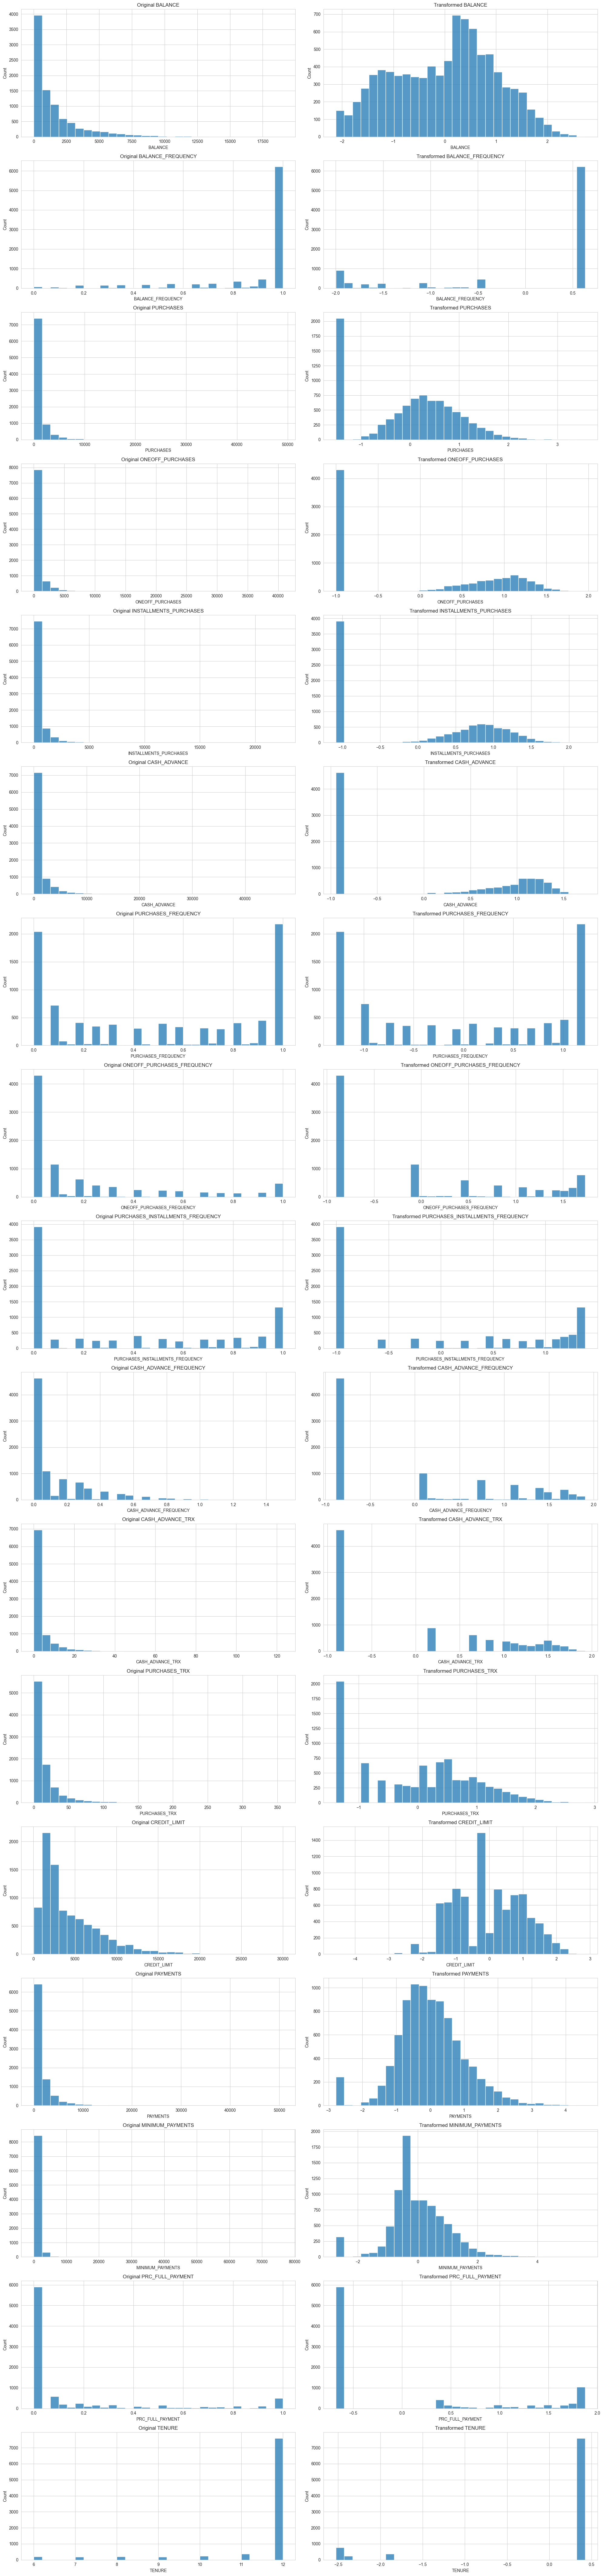

In [153]:
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer

# Application of Yeo-Johnson to all columns
pt = PowerTransformer(method='yeo-johnson')
yj_transformed_df = df.copy(deep=True)
for column in df.columns:
    data = np.array( df[column] ).reshape(-1,1)
    transformed_data = pt.fit_transform(data)
    yj_transformed_df[column] = transformed_data.flatten()

# Create a 17 row by 2 column grid for the plots
fig, axes = plt.subplots(nrows=17, ncols=2, figsize=(20, 85))
axes = axes.flatten()

# Iterate over each column and create histogram side by side
for i, column in enumerate(df.columns):
    if 2*i < len(axes):
        # Original data hisogram
        sns.histplot(df[column], bins = 30, ax = axes[2*i])
        axes[2*i].set_title(f'Original {column}')

    if 2*i + 1 < len(axes):
        # Yeo-Johnson transformed data histogram
        sns.histplot(yj_transformed_df[column], bins = 30, ax = axes[2*i+1])
        axes[2*i + 1].set_title(f'Transformed {column}')

plt.tight_layout()


In [121]:
# Before proceeding, it would be useful to scale the data. We use scikit-learn's StandardScaler for the task.
# Scaling the data
scaler = StandardScaler()
scaler.fit(df)
X_scaled = scaler.transform(df)
print(X_scaled[:5])

[[-0.73205404 -0.24988139 -0.4249337  -0.35695651 -0.34911414 -0.4668054
  -0.80664908 -0.67871619 -0.70740935 -0.67529446 -0.47608293 -0.51138082
  -0.96037969 -0.52902627 -0.29733434 -0.52558844  0.36054128]
 [ 0.78685815  0.1340494  -0.4695839  -0.35695651 -0.45460688  2.6054375
  -1.22192823 -0.67871619 -0.91708951  0.57394905  0.11003155 -0.59184052
   0.68860056  0.81854607  0.10199822  0.2341587   0.36054128]
 [ 0.44704093  0.51798018 -0.10771601  0.10884332 -0.45460688 -0.4668054
   1.26974167  2.67329468 -0.91708951 -0.67529446 -0.47608293 -0.10908229
   0.82601558 -0.38385745 -0.08852421 -0.52558844  0.36054128]
 [ 0.04901491 -1.01774295  0.23199527  0.54612295 -0.45460688 -0.3686778
  -1.0142899  -0.39938307 -0.91708951 -0.25888162 -0.32955431 -0.55161067
   0.82601558 -0.59873323 -0.35705667 -0.52558844  0.36054128]
 [-0.35884931  0.51798018 -0.4620954  -0.34731723 -0.45460688 -0.4668054
  -1.0142899  -0.39938307 -0.91708951 -0.67529446 -0.47608293 -0.55161067
  -0.90541368

### Choosing K
To decide the number of clusters, it'll be useful to run the k-means algorithm from 1 to 10 possible Ks. Plot the elbow curve to help find a final K.

Text(0.5, 1.0, 'Inertia vs Number of Clusters')

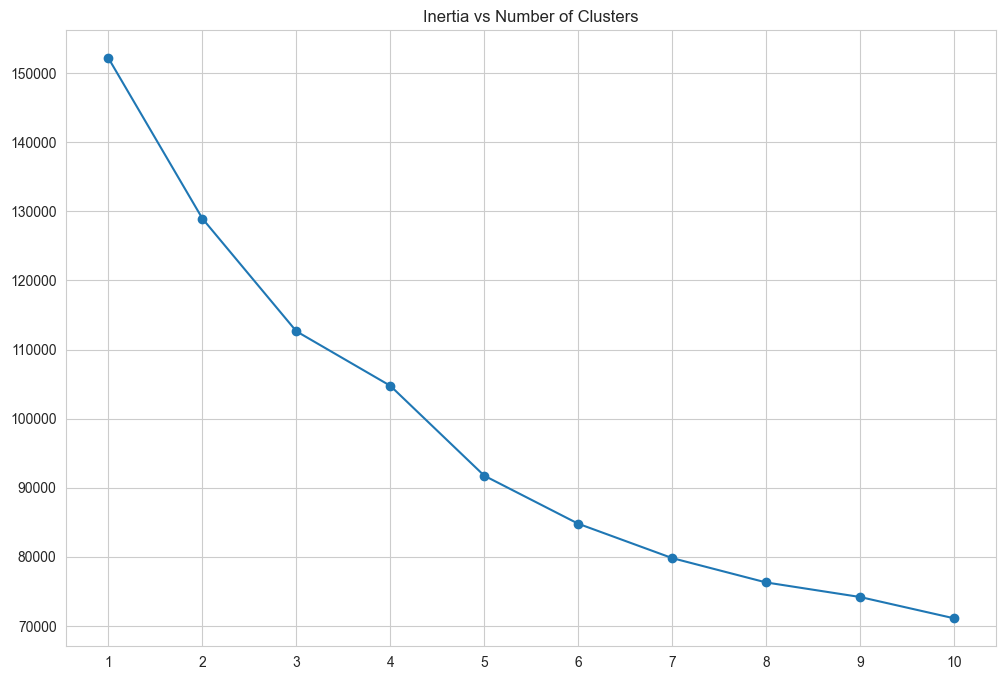

In [122]:
X = pd.DataFrame(X_scaled)
inertias = []
for k in range(1, 11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

The rate of drop of inertia seems to slow down after k=4. We use 4 clusters to move on.

In [129]:
model = KMeans(n_clusters=4)
y = model.fit_predict(X)

# Add the cluster as a column to the dataframe
df['CLUSTER'] = y + 1
df ['CLUSTER'].value_counts()

CLUSTER
1    3988
3    3353
2    1212
4     396
Name: count, dtype: int64

It'll be useful to visualise the average value of each variable per cluster.

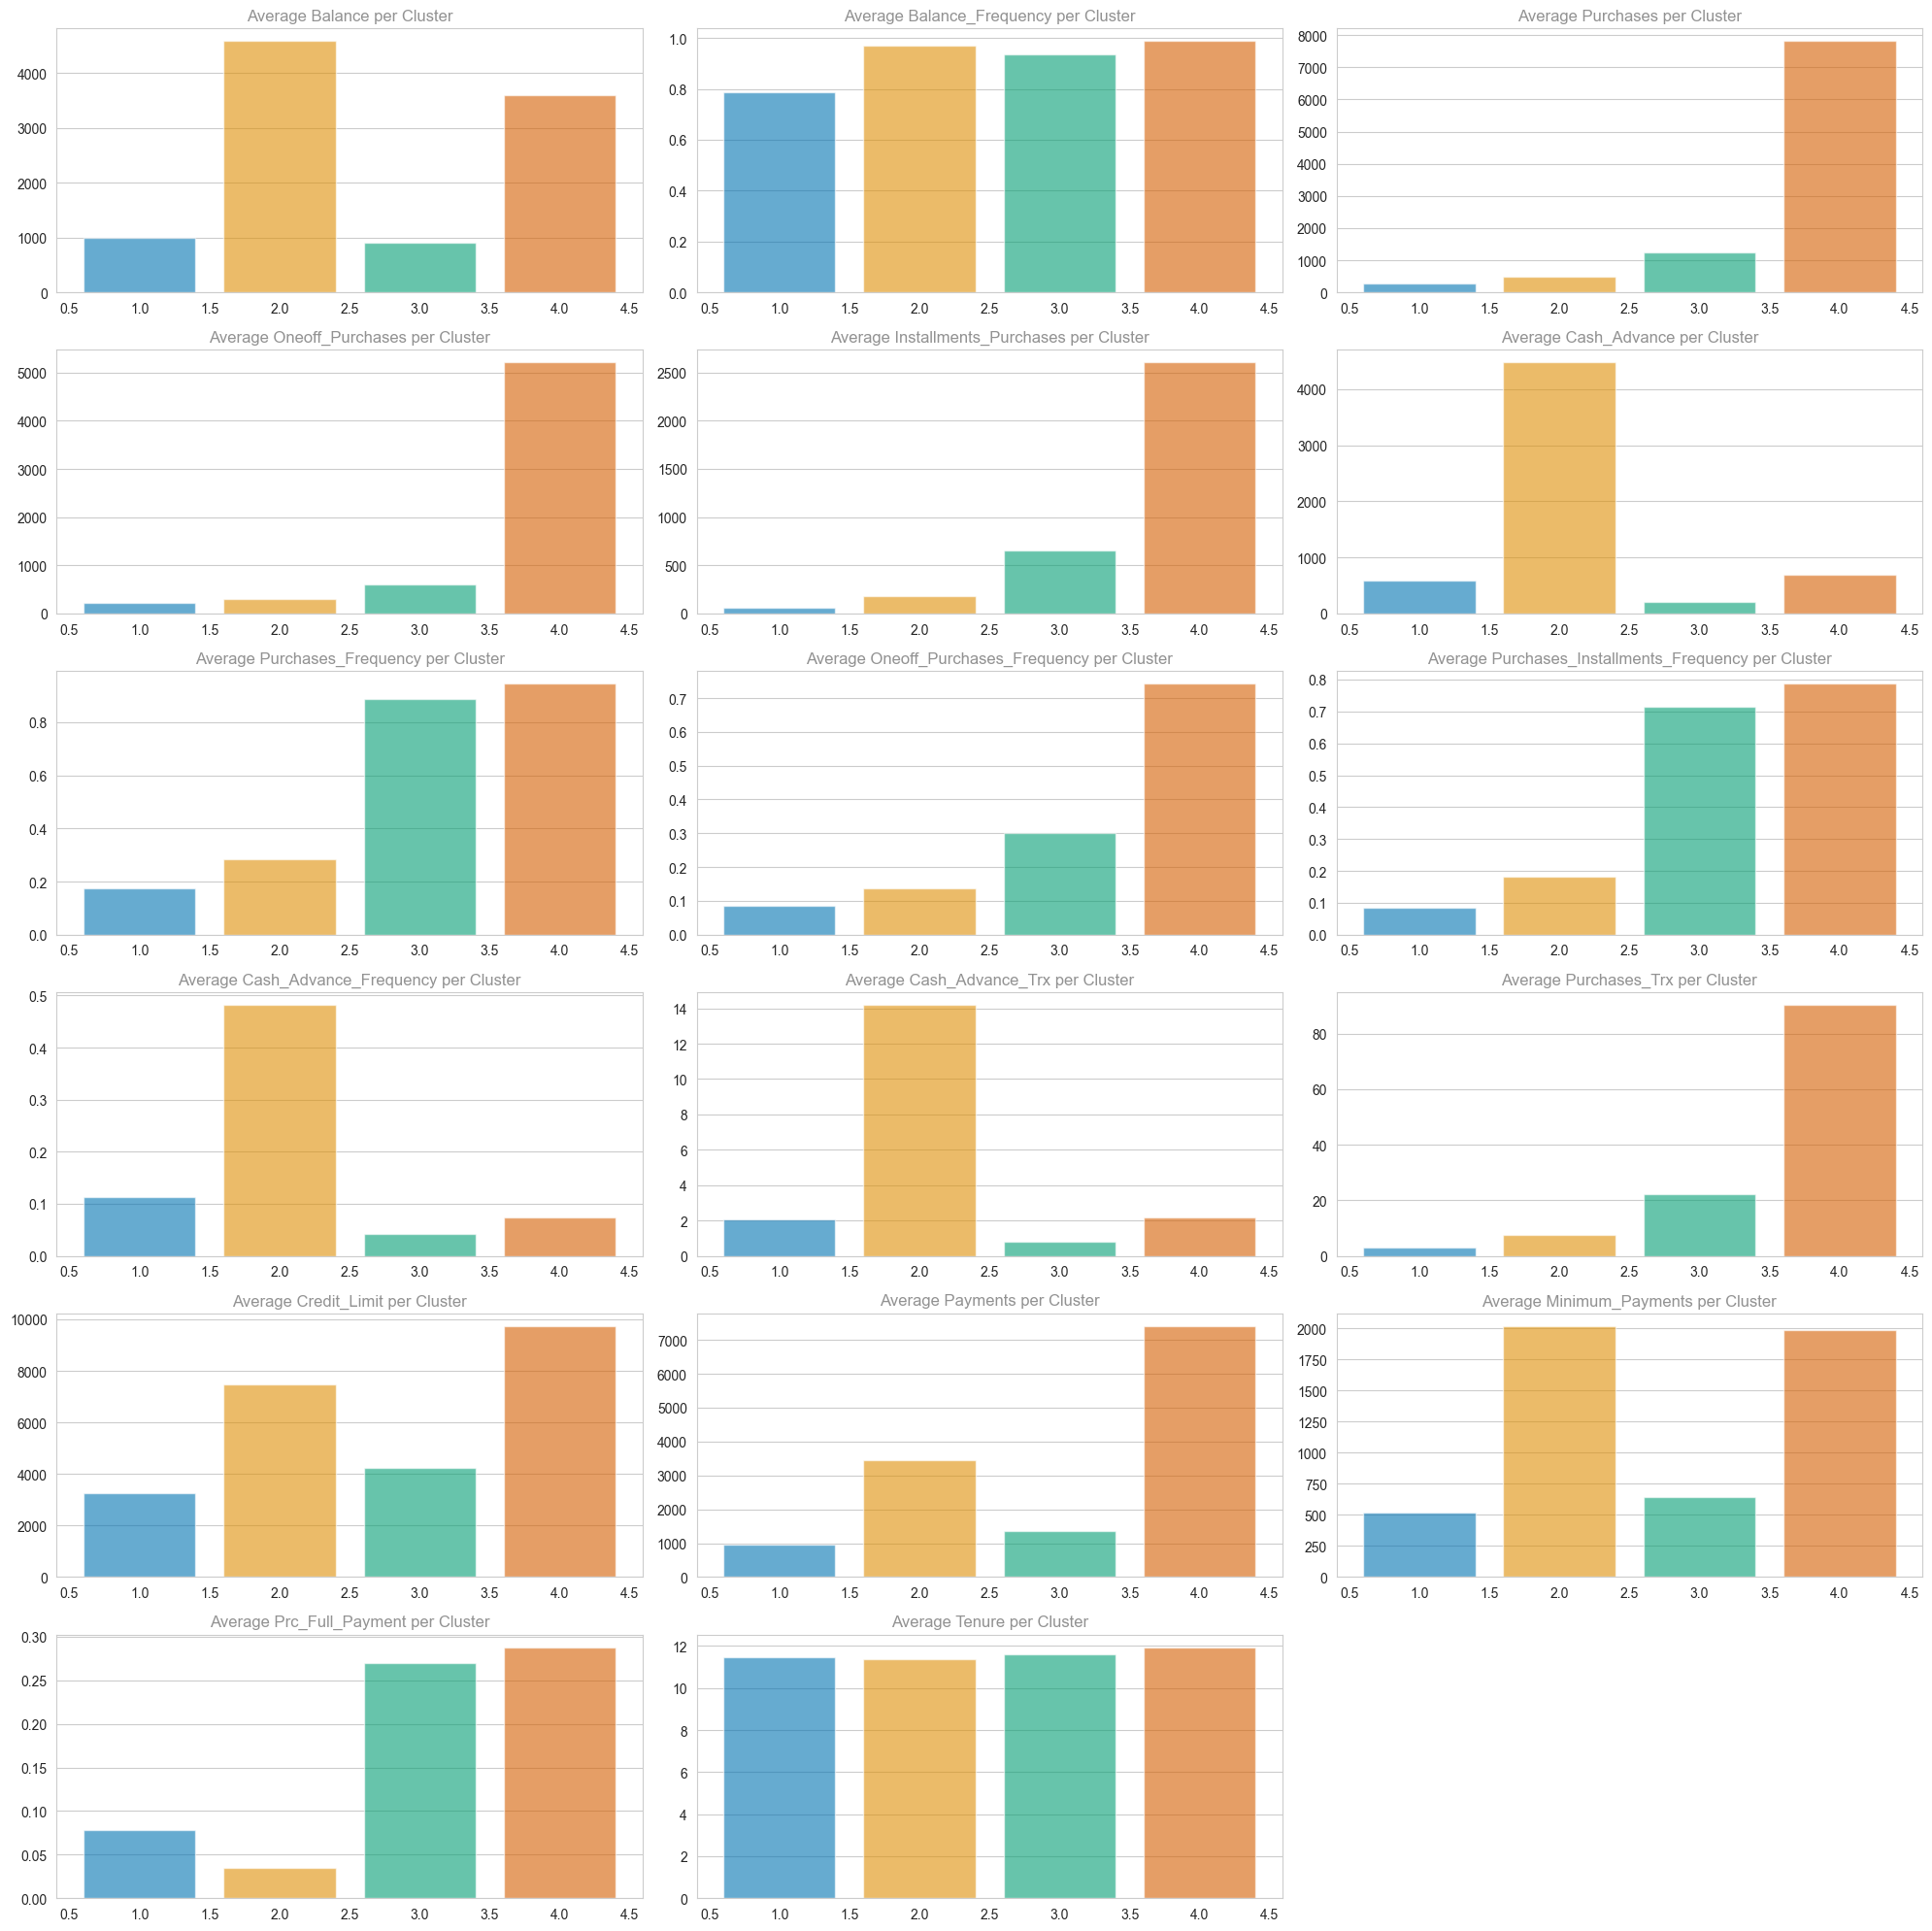

In [130]:
numeric_columns = df.select_dtypes(include = np.number).drop(['CLUSTER'], axis = 1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = df.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(6, 3, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('colorblind'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

- It can be inferred by a visual analysis of the above bar graphs that cluster 3 represents typically wealthy and high-spending individuals with high credit limits.
- Cluster 4 seems to be "low intensity" users of the card. Small purchases, small payments
- Cluster 1 seems to be generally poor clients with large average cash advance, low percentage of full payments.
- Cluster 2 are moderate users.


We can also check correlations via scatterplots.

In [125]:
numeric_columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

<Axes: xlabel='CASH_ADVANCE_FREQUENCY', ylabel='INSTALLMENTS_PURCHASES'>

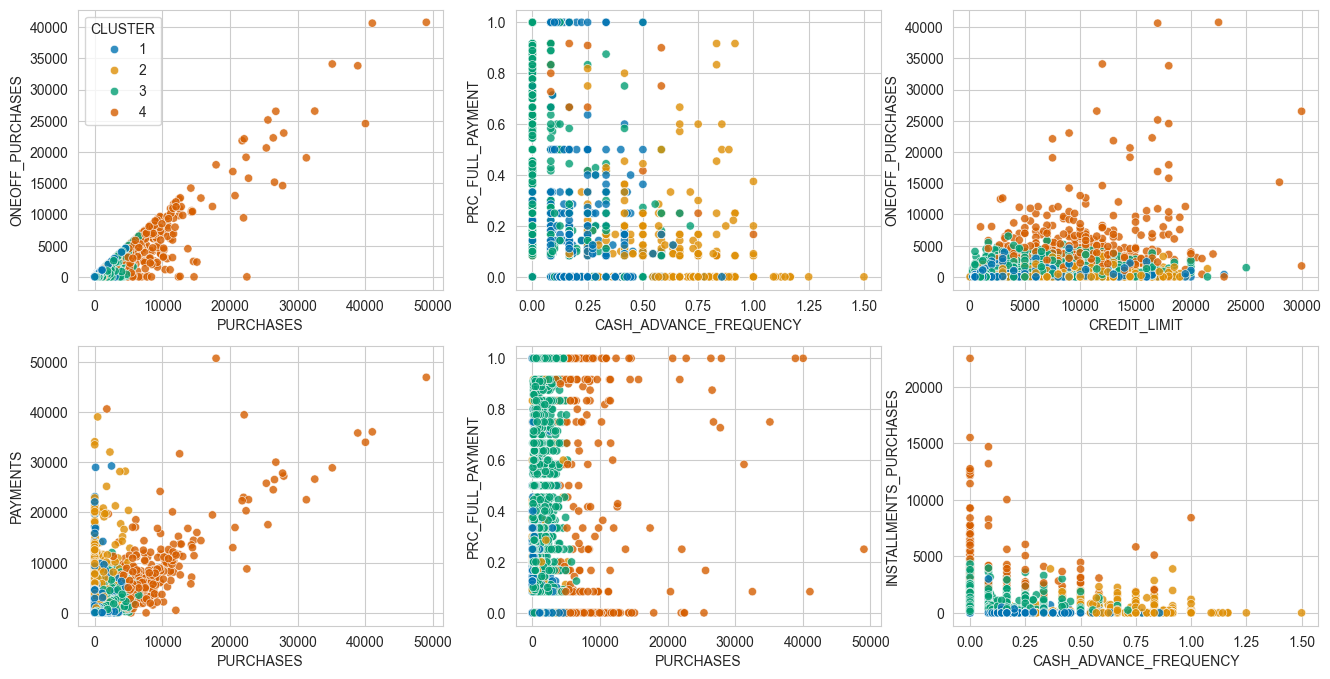

In [131]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 8))

sns.scatterplot( x = 'PURCHASES', y = 'ONEOFF_PURCHASES', hue = 'CLUSTER', data = df, palette = 'colorblind', alpha = 0.8, ax = ax1)
sns.scatterplot( x = 'CASH_ADVANCE_FREQUENCY', y = 'PRC_FULL_PAYMENT', hue = 'CLUSTER', data = df, palette = 'colorblind', alpha = 0.8, ax = ax2, legend=False)
sns.scatterplot( x = 'CREDIT_LIMIT', y = 'ONEOFF_PURCHASES', hue = 'CLUSTER', data = df, palette = 'colorblind', alpha = 0.8, ax = ax3, legend = False)
sns.scatterplot( x = 'PURCHASES', y = 'PAYMENTS', hue = 'CLUSTER', data = df, palette = 'colorblind', alpha = 0.8, ax = ax4, legend=False)
sns.scatterplot( x = 'PURCHASES', y = 'PRC_FULL_PAYMENT', hue = 'CLUSTER', data = df, palette = 'colorblind', alpha = 0.8, ax = ax5, legend=False)
sns.scatterplot( x = 'CASH_ADVANCE_FREQUENCY', y = 'INSTALLMENTS_PURCHASES', hue = 'CLUSTER', data = df, palette = 'colorblind', alpha = 0.8, ax = ax6, legend=False)
